<center>
# Предобработка данных и логистическая регрессия
<center\>

В задании вы познакомитесь с основными техниками предобработки данных и примените их для обучения модели логистической регрессии. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Данные

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам, которые были поданы в университете Мельбурна с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y.
Теперь X обозначает обучающую выборку, y — ответы на ней.

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Предобработка 

В будущем, на этих данных мы будем решать задачу логистической регрессии.

Для применения к данным логистической регрессии нужно, чтобы:
- все $X$ были числовыми,
- в матрице $X$ не было пропусков.

Поэтому базовым этапом в предобработке любых данных для логистической регрессии будет преобразование категориальных признаков и обработка пропущенных значений.

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 39 columns):
Grant.Status                              6000 non-null int64
Sponsor.Code                              5387 non-null object
Grant.Category.Code                       5387 non-null object
Contract.Value.Band...see.note.A          3539 non-null object
RFCD.Code.1                               5583 non-null float64
RFCD.Percentage.1                         5583 non-null float64
RFCD.Code.2                               5583 non-null float64
RFCD.Percentage.2                         5583 non-null float64
RFCD.Code.3                               5583 non-null float64
RFCD.Percentage.3                         5583 non-null float64
RFCD.Code.4                               5583 non-null float64
RFCD.Percentage.4                         5583 non-null float64
RFCD.Code.5                               5583 non-null float64
RFCD.Percentage.5                         5583 non-null float64
SE

Видно, что в датасете есть и числовые, и категориальные признаки. Получим списки их названий:

In [6]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Также в нём присутствуют пропущенные значения. Простым решением будет исключение всех объектов, у которых пропущено значение хотя бы одного признака. Это делается так:

In [7]:
len(data)

6000

In [8]:
len(data.dropna())

213

Видно, что тогда мы выбросим почти все данные, это не очень хорошо. Попробуем ещё несколько способов обработки пропусков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет),
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака).

Для категориальных:
- интерпретировать пропущенное значение как ещё одну категорию (это самый естественный способ, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется).

##  Задание 0. Обработка пропусков
1. Заполните пропущенные вещественные значения в X нулями и средними по столбцам, назовите полученные датафреймы X_real_zeros и X_real_mean соответственно. Для подсчёта средних используйте приведённую ниже функцию calculate_means. На вход она принимает вещественные признаки из исходного датафрейма.
2. Все категориальные признаки в X преобразуйте в строки, пропущенные значения замените какой-нибудь строкой, не встречающейся среди значений признаков (закодируйте их строкой 'NA'). Полученный датафрейм назовите X_cat.

In [9]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

X_cat = X[categorical_cols].fillna('NA').applymap(str)
X_real_zeros = X[numeric_cols].fillna(0)

In [10]:
X_real_mean = X[numeric_cols].fillna(calculate_means(X[numeric_cols]))

## Преобразование категориальных признаков

Мы разделили данные на две части: в одной присутствуют только вещественные признаки, в другой — только категориальные. 

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [11]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female', 'male'], 
                                'nationality': ['American', 'European', 'Asian', 'European', 'NA']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)

Исходные данные:

  nationality     sex
0    American    male
1    European  female
2       Asian    male
3    European  female
4          NA    male

Закодированные данные:

[[ 1.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  1.]]


В первых четырёх колонках оказалась закодирована информация о стране, в последних двух — о поле. Видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет всю имеющуюся информацию, в том числе о наличии пропущенных значений (если они перекодированы уникальными строками).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки интерфейс: функция

    encoder.fit_transform(X)
    
позволяет вычислить параметры преобразования; после этого к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то можете получить разные коды для одних и тех же признаков, и ваше решение работать не будет.

Параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что тогда подсчитанные на тесте метрики будут давать завышенные оценки качества работы алгоритма. Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [12]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для оценки качества обучения нужно разделить исходную выборку на обучающую и тестовую.

Обращаем внимание на заданный параметр для генератора случайных чисел: random_state. Результаты на обучении и тесте будут зависеть от того, как именно вы разделите объекты, поэтотому, чтобы система проверки могла точно оценить ваши результаты,  предлагается фиксировать способ разбиения.

In [13]:
from sklearn.model_selection import train_test_split

X_train_real_zeros,X_test_real_zeros, y_train, y_test = train_test_split(X_real_zeros, y, test_size=0.3, random_state=132442)
                
X_train_real_mean, X_test_real_mean = train_test_split(X_real_mean, test_size=0.3, random_state=132442)
X_train_cat_oh, X_test_cat_oh = train_test_split(X_cat_oh, test_size=0.3, random_state=132442)

## Описание классов

Итак, мы получили первые наборы данных, на которых можно обучать логистическую регрессию. Обучим её, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator — обучающий алгоритм, для которого будет производиться подбор параметров,
- param_grid — словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения — набор параметров для перебора.

Этот метод выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. За счёт использования кросс-валидации он позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring — функционал качества, максимум которого ищется кросс-валидацией; по умолчанию используется функция score() класса esimator,
- n_jobs — позволяет ускорить кросс-валидацию, выполняя её параллельно; число определяет количество одновременно запущенных задач,
- cv — количество фолдов, на которые разбивается выборка при кросс-валидации.

После инициализации класса GridSearchCV процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения вероятностей классов (в случае использования логистической регрессии) можно воспользоваться методом: 

    optimizer.predict_proba(X)
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ — лучший алгоритм,
- best\_params\_ — лучший набор параметров.

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
penalty принимает значения 'l2' или 'l1', по умолчанию устанавливается значение 'l2'. Везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с $L_2$-регуляризацией.

## Задание 1. Сравнение способов заполнения вещественных пропусков
1. Составьте две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой — средними. Рекомендуется записывать в выборки сначала вещественные, а потом категориальные признаки.
2. Обучите на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3. В качестве оптимизируемой функции используйте заданную по умолчанию.
3. Постройте два графика оценок точности +- их стандартного отклонения в зависимости от гиперпараметра и убедитесь, что вы действительно нашли её максимум. Обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv).
4. Получите две метрики качества AUC ROC на тестовой выборке и сравните их между собой. Какой способ заполнения пропущенных вещественных значений работает лучше?

Вообще говоря, не совсем логично оптимизировать на кросс-валидации функционал accuracy (заданный по умолчанию в классе логистической регрессии), а измерять на тесте AUC ROC, но это, как и ограничение размера выборки, сделано для ускорения работы процесса кросс-валидации.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
            
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

In [16]:
X_train_zeros = np.concatenate((X_train_real_zeros, X_train_cat_oh), axis = 1)
X_train_mean = np.concatenate((X_train_real_mean, X_train_cat_oh), axis = 1)
X_test_zeros = np.concatenate((X_test_real_zeros, X_test_cat_oh), axis = 1)
X_test_mean = np.concatenate((X_test_real_mean, X_test_cat_oh), axis = 1)

In [17]:
estimator = LogisticRegression()
clf_zeros = GridSearchCV(estimator, param_grid, cv = 3)
clf_zeros.fit(X_train_zeros, y_train)
clf_zeros.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


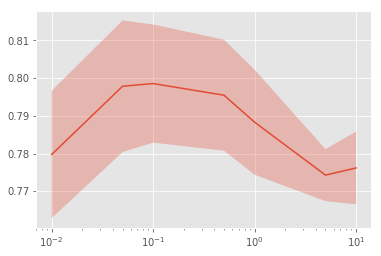

In [31]:
plot_scores(clf_zeros)

In [32]:
estimator = LogisticRegression()
clf_mean = GridSearchCV(estimator, param_grid, cv = 3)
clf_mean.fit(X_train_mean, y_train)
clf_mean.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


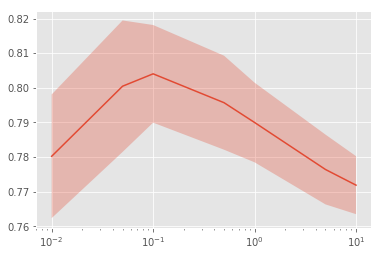

In [33]:
plot_scores(clf_mean)

In [34]:
y_zeros = clf_zeros.predict_proba(X_test_zeros)[:, 1]
roc_auc_zeros = roc_auc_score(y_test, y_zeros)
roc_auc_zeros

0.88642889349135867

In [35]:
y_mean = clf_mean.predict_proba(X_test_mean)[:, 1]
roc_auc_mean = roc_auc_score(y_test, y_mean)
roc_auc_mean

0.88740994628983672

In [36]:
roc_auc_mean - roc_auc_zeros

0.00098105279847804372

In [37]:
from sklearn.metrics import roc_curve
fpr_mean, tpr_mean, _ = roc_curve(y_test, y_mean)
fpr_zeros, tpr_zeros, _ = roc_curve(y_test, y_zeros)

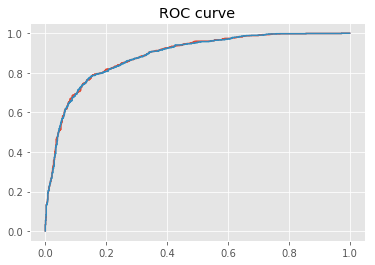

In [38]:
plt.plot(fpr_mean, tpr_mean)
plt.plot(fpr_zeros, tpr_zeros)
plt.title('ROC curve')

## Масштабирование вещественных признаков

Попробуем улучшить качество классификации. Посмотрим на данные:

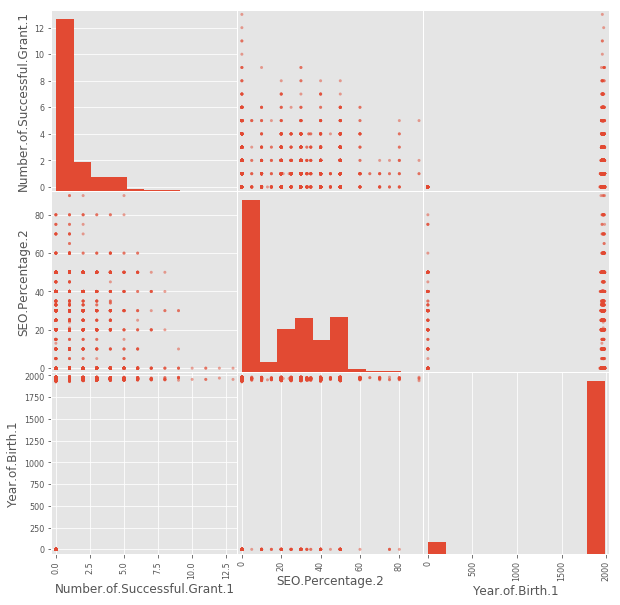

In [39]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях рекомендуется делать стандартизацию (масштабирование) признаков, чтобы они меньше отличались друг друга по модулю. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретируемость, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Задание на масштабирование вещественных признаков

1. По аналогии с вызовом one-hot encoder примените масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)
2. Сохраните ответ в переменные X_train_real_scaled и X_test_real_scaled соответственно

In [40]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

## Сравнение признаковых пространств

Посмотрим на преобразованные данные:

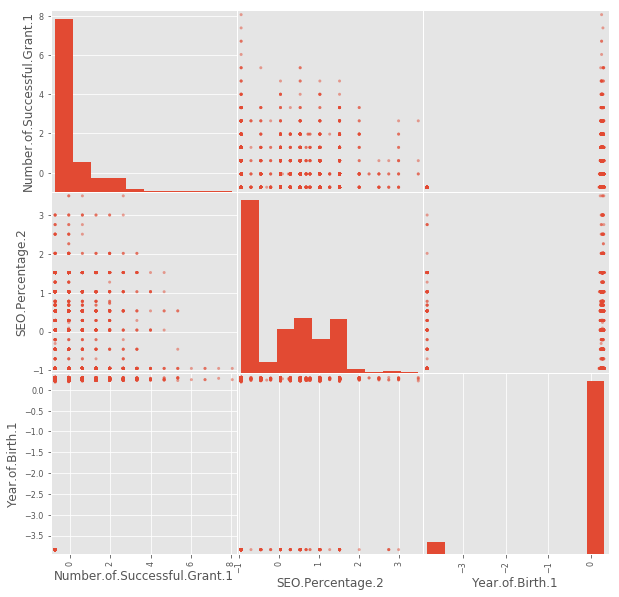

In [41]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков и их диаграммы рассеяния выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне.

## Задание 2. Сравнение качества классификации до и после масштабирования вещественных признаков
1. Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверьте, был ли найден оптимум accuracy по гиперпараметрам во время кросс-валидации.
3. Получите значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.

In [42]:
X_train_scaled = np.concatenate((X_train_real_scaled, X_train_cat_oh), axis = 1)
X_test_scaled = np.concatenate((X_test_real_scaled, X_test_cat_oh), axis = 1)

estimator = LogisticRegression()
clf_scaled = GridSearchCV(estimator, param_grid, cv = 3)
clf_scaled.fit(X_train_scaled, y_train)
clf_scaled.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


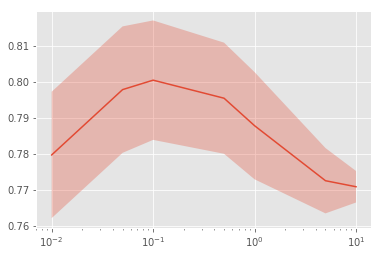

In [43]:
plot_scores(clf_scaled)

In [44]:
y_scaled = clf_scaled.predict_proba(X_test_scaled)[:, 1]
roc_auc_scaled = roc_auc_score(y_test, y_scaled)
roc_auc_scaled

0.88671751129697163

In [45]:
roc_auc_scaled - roc_auc_zeros

0.00028861780561295625